In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as s
import nltk

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Saving train.csv to train (1).csv


In [ ]:
# keeping only the alphanumeric characters
import re
sentences = []
for i in range(0,len(data)):
    #x = re.sub(r'\W+'," ", data.text[i])
    x = re.sub(r'[^a-zA-Z0-9]+'," ", data.text[i])
    #x = re.sub('\S+[0-9]\S+'," ", x)
    #x = re.sub('\S+[0-9]'," ", x)
    #x = re.sub('[0-9]\S+'," ", x)
    #x = re.sub(r'\b\w{1,2}\b', '', x)
    sentences.append(x)
    

In [ ]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk import sent_tokenize, word_tokenize, pos_tag

In [ ]:
# keeping those words which are in english dictionary 
nltk.download('words')
words = set(nltk.corpus.words.words())
for i in range(0,len(sentences)):
    sentences[i] = " ".join(w for w in nltk.wordpunct_tokenize(sentences[i]) if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
'''# filtering all sentences using for loop
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
collection = [] 
for i in range(0,len(sentences)):   
    # using spacy
    doc = nlp(sentences[i].lower())
    store = []
    for nounchunks in doc.noun_chunks:
        store = store+list(nounchunks)
    store = str(store).replace(',',' ')
    store = store[1:-1]

    # using nltk pos tag
    word1 = word_tokenize(store)
    store = pos_tag(word1)
    store = list(filter(lambda x: x[1][0:2] == 'NN', store))
    try:
        store = list(list(zip(*store))[0])
    except:
        pass
    store = ' '.join(store)
    collection.append(store)'''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# filtering empty strings
collection = list(filter(None, collection))

In [ ]:
len(collection)

6880

In [ ]:
len(collection)

7613

In [ ]:
data['atis_flight'].value_counts()

atis_flight            3665
atis_airfare            423
atis_ground_service     255
atis_airline            157
atis_abbreviation       147
atis_aircraft            81
atis_flight_time         54
atis_quantity            51
Name: atis_flight, dtype: int64

<BarContainer object of 8 artists>

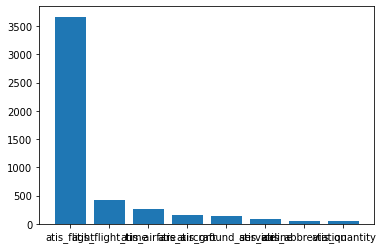

In [ ]:
import seaborn as s
plt.bar(data['atis_flight'].unique(),data['atis_flight'].value_counts())

In [ ]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# loading stop words
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# stemming words

stemmer = PorterStemmer()
def tokenizer(keyword):
    return [stemmer.stem(w) for w in keyword.split(' ')]

In [ ]:
# tfidf vectorizer

tfidf = TfidfVectorizer(lowercase = True, tokenizer = tokenizer, stop_words = sw)

In [ ]:
df = pd.DataFrame(tfidf.fit_transform(data.iloc[:,1]).toarray(), index = data.iloc[:,1], columns = tfidf.get_feature_names())

In [ ]:
# function to preprocess data and batch it
from tensorflow.keras.utils import to_categorical

def pipeline(img,label):
  label = to_categorical(label)
  data=tf.data.Dataset.from_tensor_slices((img,label))
  data=data.shuffle(10000)
  return data

In [ ]:
data['atis_flight'] = pd.Categorical(data['atis_flight'])
data['code'] = data['atis_flight'].cat.codes

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 5, test_size=0.1, random_state=0)
sss.get_n_splits(df, data['code'])
for train_idx, test_idx in sss.split(df,data['code']):
    X_train=df.iloc[train_idx,:]
    Y_train=data['code'][train_idx]
    X_valtest=df.iloc[test_idx,:]
    Y_valtest=data['code'][test_idx]

X_valtest.index = range(0,len(X_valtest))
Y_valtest.index = range(0,len(Y_valtest))
sss = StratifiedShuffleSplit(n_splits = 5, test_size=0.4, random_state=1)
sss.get_n_splits(X_valtest, Y_valtest)
for i, j in sss.split(X_valtest, Y_valtest):
  X_val = X_valtest.iloc[i,:]
  Y_val = Y_valtest[i]
  X_test = X_valtest.iloc[j,:]
  Y_test = Y_valtest[j]


In [ ]:
# running training dataset through the pipeline
train = pipeline(X_train, Y_train).batch(500)
validate = pipeline(X_val, Y_val).batch(200)
test = pipeline(X_test, Y_test).batch(200)

In [ ]:
'''data['atis_flight'] = pd.Categorical(data['atis_flight'])
data['code'] = data['atis_flight'].cat.codes

# running training dataset through the pipeline
train = pipeline(df[:4200], data['code'][:4200]).batch(500)
validate = pipeline(df[4200:4600], data['code'][4200:4600]).batch(200)
test = pipeline(df[4600:4800], data['code'][4600:4800]).batch(200)'''

In [ ]:
'''# splitting test data into test and validation data
validate = train.take(200).batch(200)
train = train.skip(200)'''

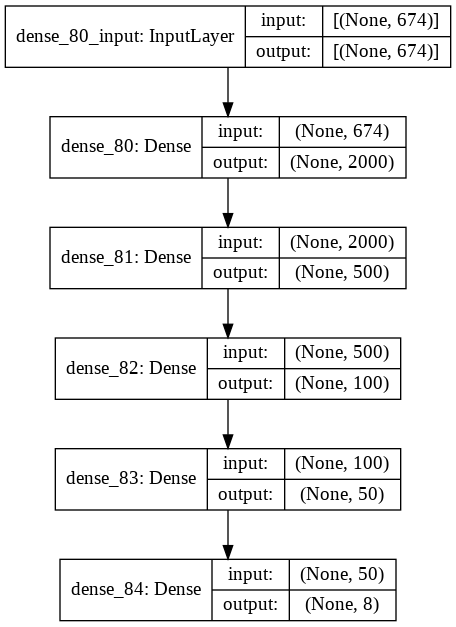

In [ ]:
# setting up the model
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential([
    layers.Dense(2000, activation = 'relu', input_shape = (674,)),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(50, activation = 'relu'),
    layers.Dense(8, activation = 'softmax')]
)

network.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

keras.utils.plot_model(network, show_shapes = True)

In [ ]:
70:70:45:25:25:15:8:1/259

In [ ]:
data['code'].value_counts()

4    3665
2     423
6     255
3     157
0     147
1      81
5      54
7      51
Name: code, dtype: int64

In [ ]:
# fitting the model
from keras.callbacks import EarlyStopping
#init_weights = network.get_weights()
class_weight = {7:70/259,
                5:70/259,
                1:45/259,
                0:25/259,
                3:25/259,
                6:15/259,
                2:8/259,
                4:1/259}
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
info = network.fit(train, validation_data = validate, epochs = 100, verbose =1, class_weight = class_weight)

Epoch 1/100
9/9 [==============================] - 2s 151ms/step - loss: 0.0463 - accuracy: 0.0579 - val_loss: 2.7157 - val_accuracy: 0.1103
Epoch 2/100
9/9 [==============================] - 1s 132ms/step - loss: 0.0237 - accuracy: 0.4458 - val_loss: 0.4814 - val_accuracy: 0.9345
Epoch 3/100
9/9 [==============================] - 1s 132ms/step - loss: 0.0055 - accuracy: 0.9073 - val_loss: 0.3500 - val_accuracy: 0.9172
Epoch 4/100
9/9 [==============================] - 1s 129ms/step - loss: 0.0022 - accuracy: 0.9505 - val_loss: 0.3398 - val_accuracy: 0.9379
Epoch 5/100
9/9 [==============================] - 1s 132ms/step - loss: 0.0017 - accuracy: 0.9531 - val_loss: 0.2564 - val_accuracy: 0.9414
Epoch 6/100
9/9 [==============================] - 1s 129ms/step - loss: 0.0010 - accuracy: 0.9680 - val_loss: 0.0847 - val_accuracy: 0.9828
Epoch 7/100
9/9 [==============================] - 1s 131ms/step - loss: 5.4449e-04 - accuracy: 0.9823 - val_loss: 0.1389 - val_accuracy: 0.9483
Epoch 8/1

In [ ]:
network.evaluate(test)

1/1 [==============================] - 0s 37ms/step - loss: 0.0885 - accuracy: 0.9794


[0.08850158751010895, 0.9793814420700073]